In [1]:

import random

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import OxfordIIITPet

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
TORCH_GEN = torch.manual_seed(RANDOM_SEED)

In [5]:
PATCH_SIZE = 16

In [2]:
ds = OxfordIIITPet(root='data', download=True, split='trainval', transform=ToTensor())

train_ds, val_ds = random_split(ds, [0.8, 0.2])

First lets write a basic function to visualize a grid of images with optional parameters to display the images with denotations whether they were correctly classified or not.

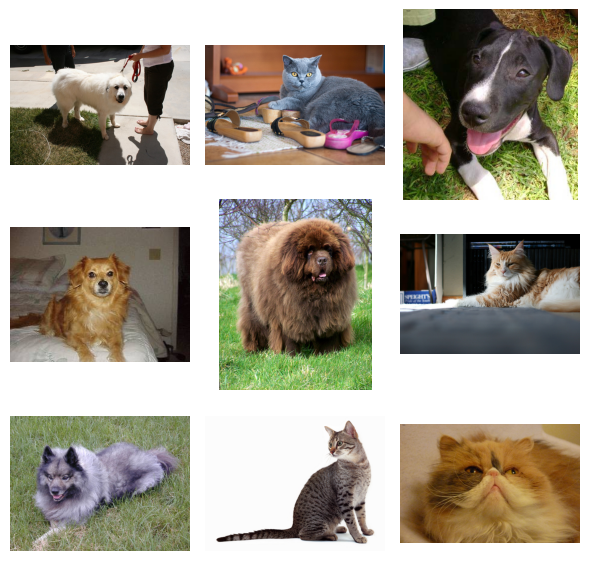

In [3]:
import math

def plot_imgs(imgs, pred_labels=None, true_labels=None, figsize=(12, 12)):
    num_imgs = len(imgs)
    nrows = int(math.ceil(math.sqrt(num_imgs)))
    ncols = int(math.ceil(num_imgs / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if num_imgs > 1 else [axes]

    for i, (img, ax) in enumerate(zip(imgs, axes)):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')

        if pred_labels is not None and true_labels is not None:
            symbol = '✓' if pred_labels[i] == true_labels[i] else '✗'
            color = 'limegreen' if pred_labels[i] == true_labels[i] else 'red'
            ax.text(0, 0.5, symbol, color=color, fontsize=40,
                    ha='right', va='top', transform=ax.transAxes,
                    fontweight='bold')

    plt.tight_layout()
    plt.show()


imgs, labels = map(list, zip(*[ds[i] for i in random.sample(range(len(ds)), 9)]))
fake_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plot_imgs(imgs, figsize=(6, 6))

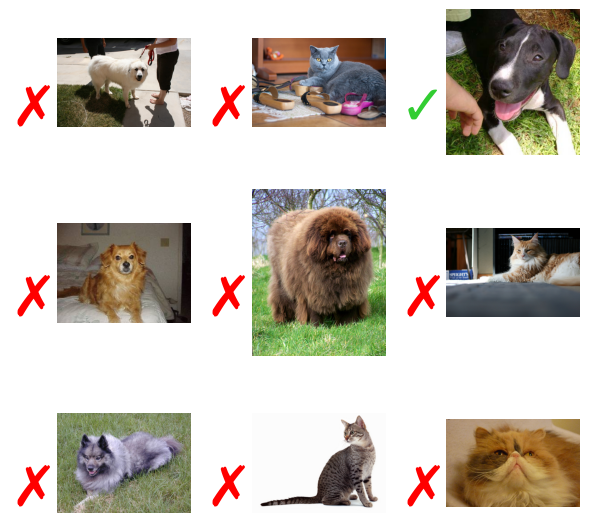

In [4]:
plot_imgs(imgs, fake_labels, labels, figsize=(6, 6))

Before implementing a vision transformer, we need to represent images in a format the model can understand. This requires creating "patches" – dividing the image into many smaller, equal-sized chunks. By treating the image as a sequence of patches (read from left to right, like a book), the transformer can then imbibe the image data!